In [1]:
import numpy as np
import json 
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
from networkx.algorithms import community

import pquality
import cdlib
from cdlib import evaluation
from cdlib import algorithms
from cdlib import viz
from cdlib import ensemble
from cdlib import readwrite

C:\Users\valen\PYTHON_3.7\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plot_communities_dimentions(coms):
    myd = {}
    for t in coms:
        lunghezza = len(t)

        if str(lunghezza) in myd:
            myd[str(lunghezza)] = myd[str(lunghezza)] + 1
        else:
            myd[str(lunghezza)] = 1

    print(myd)
    plt.figure(figsize=(20,5))
    plt.bar(myd.keys(), myd.values(), color='g')

In [3]:
g = nx.read_edgelist('network.csv', data=(('weight', int),('industry',int)) , delimiter=",")

In [4]:
NNODES = g.number_of_nodes()
NEDGES = g.number_of_edges()

print("Number of Nodes: ", NNODES)
print("Number of Edged: ", NEDGES)

Number of Nodes:  14875
Number of Edged:  43932


In [5]:
def print_bold_str(s):
    return "\033[1m" + s + "\033[0m"

# 1. Community Discovery Algorithms

In [6]:
def get_list_of_tuples_from_NodeClustering(coms):
    return [tuple(x) for x in coms.communities]

### B. K-Cliques 

Parameter tuning su k usando random_search

Uso Kclique di cdlib e poi lo converto in lista di tuple per usare pquality

## Optimization k-clique

In [7]:
k_num = ensemble.Parameter(name="k", start=3, end=7, step=1)

In [8]:
# Prendiamo kclique dal file pickle creato 
import pickle
with open('kclique.pickle', 'rb') as f:
    coms_k = pickle.load(f)

In [9]:
coms_k, scoring = ensemble.random_search(graph=g, method=algorithms.kclique,
                                                       parameters=[k_num],
                                                       quality_score=evaluation.erdos_renyi_modularity,
                                                       instances=3, aggregate=max)

print("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(coms_k.communities, coms_k.method_parameters, scoring))


'\ncoms_k, scoring = ensemble.random_search(graph=g, method=algorithms.kclique,\n                                                       parameters=[k_num],\n                                                       quality_score=evaluation.erdos_renyi_modularity,\n                                                       instances=3, aggregate=max)\n\nprint("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(coms_k.communities, coms_k.method_parameters, scoring))\n'

In [10]:
# Salvo communities in un file pickle visto il costo comutazionale
import pickle
with open('kclique.pickle', 'wb') as f:
    pickle.dump(coms_k, f)

In [11]:
coms_k_tuple = get_list_of_tuples_from_NodeClustering(coms_k)

In [12]:
print("Numero di communities: ", len(coms_k_tuple))

Numero di communities:  2073


{'5493': 1, '11': 1, '8': 1, '7': 4, '6': 17, '5': 300, '4': 946, '3': 803}


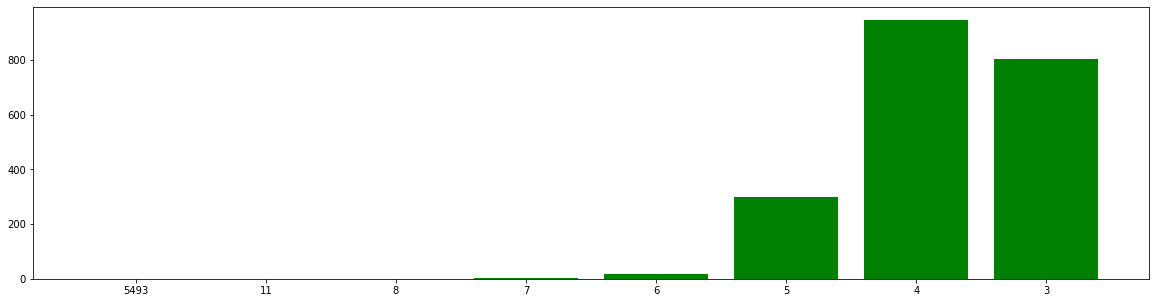

In [13]:
# Analizziamo la cardinalità delle communities
plot_communities_dimentions(coms_k_tuple)

In [14]:
# Stampiamo i valori di interesse per l'analisi
print(print_bold_str("Average Internal Degree:"), coms_k.average_internal_degree())
print(print_bold_str("Erdos Renyi Modularity:"), coms_k.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), coms_k.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), coms_k.modularity_density())
print(print_bold_str("Z Modularity:"), coms_k.z_modularity())
print(print_bold_str("Triangle Partecipation Ratio:"), coms_k.triangle_participation_ratio())

Average Internal Degree: FitnessResult(min=2.0, max=10.54178044784271, score=2.7626688662173766, std=0.7116964494780297)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=0.7806222996697043, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.13230906388459876, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=-7342.904321348464, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=0.9738293996054578, std=None)
Triangle Partecipation Ratio: FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


In [15]:
results = pquality.pquality_summary(g, coms_k_tuple)
results['Indexes']

,min,max,avg,std
Index,,,,
Internal Density,0.00048,0.250000,0.248572,0.010722
Edges inside,3.00000,28953.000000,19.435118,635.638672
Average Degree,2.00000,10.541780,2.762669,0.711696
FOMD,0.00000,0.500000,0.008195,0.055971
TPR,1.00000,1.000000,1.000000,0.000000
Expansion,0.00000,259.333333,14.789562,31.477863
Cut Ratio,0.00000,0.017438,0.000995,0.002117
Conductance,0.00000,0.992347,0.527150,0.336354
Normalized Cut,0.00000,1.001124,0.527847,0.336928


In [16]:
results['Modularity']

,value
Index,
Modularity (no overlap),0.132309


# C. Louvain

Ottimizziamo i parametri della funzione e salviamo le communities trovate

## Optimization Louvain

In [17]:
resolution = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
randomize = ensemble.BoolParameter(name="randomize")

In [18]:
coms_louv, scoring = ensemble.random_search(graph=g, method=algorithms.louvain,
                                                       parameters=[resolution, randomize],
                                                       quality_score=evaluation.newman_girvan_modularity,
                                                       instances=5, aggregate=max)

print("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(coms_louv.communities, coms_louv.method_parameters, scoring))

Communities:
 [['FREELANCE', 'POLITECNICO DI MILANO', "UNIVERSITÀ DEGLI STUDI DI ROMA 'LA SAPIENZA'", 'ITALFERR SPA', 'LUISS GUIDO CARLI', 'UNIVERSITÀ DEGLI STUDI DI BOLOGNA', 'SELF EMPLOYED', 'CINECA', 'CONFINDUSTRIA', 'APPLE DEVELOPER ACADEMY | ', 'ICONSULTING SRL', 'OSSERVATORI DIGITAL INNOVATION', 'KASANOVA SPA', 'KION', 'TEIKOS LAB SRL', 'ZUGEER', 'UNIVERSITÀ DEGLI STUDI DI NAPOLI FEDERICO II', 'UNIVERSITÀ DEGLI STUDI DI FIRENZE', 'GORI - WINE & SPIRITS LOGISTICS', 'INAIL', 'MARKAS SRL', 'UNIVERSITÀ DEGLI STUDI DI CATANIA', 'UNIRSM - UNIVERSITÀ DEGLI STUDI DELLA REPUBBLICA DI SAN MARINO', 'VARIE', 'STUDIO DI ARCHITETTURA', 'GRUPPO CEPU', 'REGIONE CAMPANIA', "MINISTERO ISTRUZIONE UNIVERSITA' E RICERCA", 'UNIVERSITÀ DEGLI STUDI DI GENOVA', 'YVES ROCHER', 'UNIVERSITA DI TOR VERGATA', 'P.P.G.', 'STUDIO ARCHEFICE', 'UNIVERSITÀ', 'PRIVATI', 'UNIVERSITÀ TELEMATICA PEGASO', 'STUDIO TECNICO', 'PRAXI SPA', 'MARINA MILITARE', 'GRUPPO FERROVIE DELLO STATO ITALIANE', 'RFI RETE FERROVIARIA ITAL

Scoring: FitnessResult(min=None, max=None, score=0.6258714680547095, std=None)


In [19]:
import pickle
with open('louvain.pickle', 'wb') as f:
    pickle.dump(coms_louv, f)

In [20]:
coms_louv_tuple = get_list_of_tuples_from_NodeClustering(coms_louv)

In [21]:
print("Numero di communities: ", len(coms_louv_tuple))

Numero di communities:  792


In [22]:
coms_louv_tuple

[('FREELANCE',
  'POLITECNICO DI MILANO',
  "UNIVERSITÀ DEGLI STUDI DI ROMA 'LA SAPIENZA'",
  'ITALFERR SPA',
  'LUISS GUIDO CARLI',
  'UNIVERSITÀ DEGLI STUDI DI BOLOGNA',
  'SELF EMPLOYED',
  'CINECA',
  'CONFINDUSTRIA',
  'APPLE DEVELOPER ACADEMY | ',
  'ICONSULTING SRL',
  'OSSERVATORI DIGITAL INNOVATION',
  'KASANOVA SPA',
  'KION',
  'TEIKOS LAB SRL',
  'ZUGEER',
  'UNIVERSITÀ DEGLI STUDI DI NAPOLI FEDERICO II',
  'UNIVERSITÀ DEGLI STUDI DI FIRENZE',
  'GORI - WINE & SPIRITS LOGISTICS',
  'INAIL',
  'MARKAS SRL',
  'UNIVERSITÀ DEGLI STUDI DI CATANIA',
  'UNIRSM - UNIVERSITÀ DEGLI STUDI DELLA REPUBBLICA DI SAN MARINO',
  'VARIE',
  'STUDIO DI ARCHITETTURA',
  'GRUPPO CEPU',
  'REGIONE CAMPANIA',
  "MINISTERO ISTRUZIONE UNIVERSITA' E RICERCA",
  'UNIVERSITÀ DEGLI STUDI DI GENOVA',
  'YVES ROCHER',
  'UNIVERSITA DI TOR VERGATA',
  'P.P.G.',
  'STUDIO ARCHEFICE',
  'UNIVERSITÀ',
  'PRIVATI',
  'UNIVERSITÀ TELEMATICA PEGASO',
  'STUDIO TECNICO',
  'PRAXI SPA',
  'MARINA MILITARE',
  'G

{'1299': 1, '1180': 1, '1010': 1, '979': 1, '904': 1, '869': 1, '658': 1, '442': 1, '401': 1, '397': 1, '379': 1, '323': 1, '298': 1, '278': 1, '275': 1, '261': 1, '245': 1, '239': 1, '213': 1, '206': 1, '203': 1, '184': 1, '153': 1, '122': 1, '117': 1, '111': 2, '109': 1, '91': 1, '81': 1, '76': 1, '71': 1, '50': 1, '41': 1, '40': 1, '21': 1, '18': 1, '12': 2, '11': 2, '10': 5, '9': 2, '8': 4, '7': 8, '6': 9, '5': 67, '4': 184, '3': 149, '2': 323}


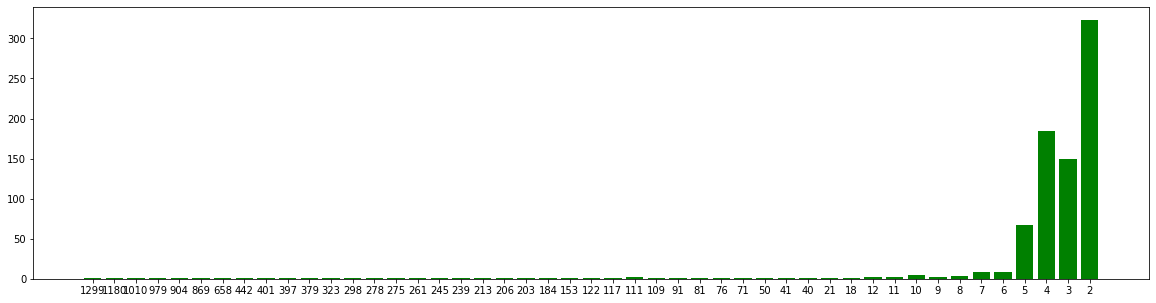

In [23]:
plot_communities_dimentions(coms_louv_tuple)

In [24]:
# Valori di misure utilizzati nell'analisi
print(print_bold_str("Average Internal Degree:"), coms_louv.average_internal_degree())
print(print_bold_str("Erdos Renyi Modularity:"), coms_louv.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), coms_louv.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), coms_louv.modularity_density())
print(print_bold_str("Z Modularity:"), coms_louv.z_modularity())
print(print_bold_str("Triangle Partecipation Ratio:"), coms_louv.triangle_participation_ratio())

Average Internal Degree: FitnessResult(min=1.0, max=6.46782431052094, score=2.0657841788855262, std=1.0790353523226504)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=0.6361914087342357, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.6258714680547095, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=451.6338829021598, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=4.221898087802154, std=None)
Triangle Partecipation Ratio: FitnessResult(min=0.0, max=1.0, score=0.5330816048843285, std=0.48322863702259033)


In [25]:
results = pquality.pquality_summary(g, coms_louv_tuple)
results['Indexes']

,min,max,avg,std
Index,,,,
Internal Density,0.00075,0.250000,0.228102,0.058792
Edges inside,1.00000,3166.000000,37.428030,240.580269
Average Degree,1.00000,6.467824,2.065784,1.079035
FOMD,0.00000,0.500000,0.042481,0.108877
TPR,0.00000,1.000000,0.533082,0.483229
Expansion,0.00000,4.534746,0.098514,0.413378
Cut Ratio,0.00000,0.000331,0.000007,0.000029
Conductance,0.00000,0.480902,0.019159,0.070805
Normalized Cut,0.00000,0.542099,0.019577,0.072869


In [26]:
results['Modularity']

,value
Index,
Modularity (no overlap),0.625871


### D. Label Propagation

In [27]:
coms_label = algorithms.label_propagation(g)

In [28]:
import pickle
with open('label.pickle', 'wb') as f:
    pickle.dump(coms_label, f)

In [29]:
readwrite.write_community_json(coms_label,'Label_comms.json')

In [30]:
coms_label_tuple = get_list_of_tuples_from_NodeClustering(coms_label)

In [31]:
print("Numero di communities: ", len(coms_label_tuple))

Numero di communities:  2110


In [32]:
coms_label_tuple

[('',
  'BYOU MUTUI',
  'FILENI',
  'DOUGLAS',
  'INDIRE - ISTITUTO NAZIONALE DI DOCUMENTAZIONE INNOVAZIONE E RICERCA EDUCATIVA',
  'MEDIALOGIC SRL',
  'ERREBIAN SPA',
  'FONDAZIONE GOLINELLI',
  'ALCOTECH',
  'VARIOUS BUSINESS SCHOOLS UNIVERISTIES CONFERENCES',
  'CONSULENTE FINANZIARIO',
  'SARDEGNA IT',
  'BITFINEX',
  'CENTRALE ATTIVITÀ FINANZIARIE SPA',
  'BUSINESS INTEGRATION PARTNERS - BIP',
  'FRONERI',
  'KPMG SPA',
  'ENAIP FRIULI VENEZIA GIULIA',
  'CAPITALIA SPA',
  'INFOKLIX',
  'CLASSE EDITORI',
  'ALMAWAVE',
  'SALVATORE FERRAGAMO',
  'MARSH RISK CONSULTING',
  'ROYAL & SUNALLIANCE VITA SPA',
  'AFONE PAIEMENT',
  'EBILLING SPA',
  'AGENZIA PRINCIPALE DI SARZANA',
  'CASSA AREASALUS',
  'CYBERGON',
  'BID COMPANY',
  'NEW DEAL ADVISORS',
  'DOKA',
  'STUDIO TRIBUTARIO SODINI',
  'INVESTITORI SGR',
  'BRIVE TONNELIERS',
  'AVM GMBH',
  'ROLO BANCA SPA',
  'DATLAS',
  'MULTICART',
  'EQUITER SPA',
  'RSA',
  'BRT',
  'HOTELSCAN',
  'FINCANTIERI SPA',
  'CORIANT',
  'DF SPO

{'7377': 1, '46': 1, '40': 1, '17': 1, '16': 1, '15': 3, '14': 2, '13': 4, '12': 8, '11': 12, '10': 13, '9': 16, '8': 28, '7': 58, '6': 80, '5': 165, '4': 398, '3': 589, '2': 729}


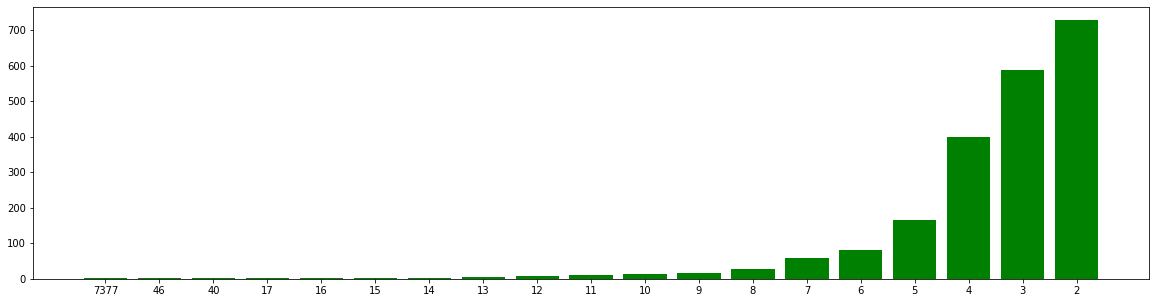

In [33]:
plot_communities_dimentions(coms_label_tuple)

In [34]:
# Misure utilizzate nell'analisi
print(print_bold_str("Average Internal Degree:"), coms_label.average_internal_degree())
print(print_bold_str("Erdos Renyi Modularity:"), coms_label.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), coms_label.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), coms_label.modularity_density())
print(print_bold_str("Z Modularity:"), coms_label.z_modularity())
print(print_bold_str("Triangle Partecipation Ratio:"), coms_label.triangle_participation_ratio())

Average Internal Degree: FitnessResult(min=1.0, max=8.150467669784465, score=1.9717063534546693, std=0.9093002123641278)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=0.6369332164669118, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.24432238042716292, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=746.2683932082175, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=0.8310400426647663, std=None)
Triangle Partecipation Ratio: FitnessResult(min=0.0, max=1.0, score=0.5744801206233439, std=0.47024127929248494)


In [35]:
results = pquality.pquality_summary(g, coms_label_tuple)
results['Indexes']

,min,max,avg,std
Index,,,,
Internal Density,0.000276,0.250000,0.224264,0.049709
Edges inside,1.000000,30063.000000,18.384834,654.241177
Average Degree,1.000000,8.150468,1.971706,0.909300
FOMD,0.000000,0.500000,0.057007,0.115956
TPR,0.000000,1.000000,0.574480,0.470241
Expansion,0.000000,3.333333,0.676389,0.611828
Cut Ratio,0.000000,0.000224,0.000046,0.000041
Conductance,0.000000,0.666667,0.232650,0.198076
Normalized Cut,0.000000,0.666803,0.232749,0.198065


In [36]:
results['Modularity']

,value
Index,
Modularity (no overlap),0.244322


## Demon Angel

## Optimization Demon

In [37]:
# epsilon – merging threshold in [0,1], default 0.25.
# min_com_size – minimum community size, default 3.

eps = ensemble.Parameter(name="epsilon", start=0.1, end=0.6, step=0.1)
size = ensemble.Parameter(name="min_com_size", start=3, end=5,step=1)

In [38]:
coms_demon, scoring = ensemble.random_search(graph=g, method=algorithms.demon,
                                                       parameters=[eps, size],
                                                       quality_score=evaluation.erdos_renyi_modularity,
                                                       instances=5, aggregate=max)

print("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(coms_demon.communities, coms_demon.method_parameters, scoring))

Communities:
 [['(ISC)2 CHAPTER', '-', '.', '01DESIGN', '01TRIBE', '1861UNITED', '2-TORRI.COM SRL - ACCELERATORI DI BUSINESS', '24ORE BUSINESS SCHOOL', '2R CAPITAL SPA', '3ESSE SRL RGI GROUP SPA', '3G DEAL & RESEARCH', '3H PARTNERS', '3M', '3M SRL', '3RDPLACE', '3TI PROGETTI SPA', 'A. MANZONI & C.', 'A.S. WATSON GROUP', 'A.T. KEARNEY', 'A1 LIFE', 'A2A', 'ABACUS', 'ABB', 'ABENERGIE', 'ABLE TECH', 'ABN AMRO', 'ABSOLUTE INTERPRETING & TRANSLATIONS LIMITED', 'ACCENTURE', 'ACCURACY', 'ACEA', 'ACLI - ASSOCIAZIONI CRISTIANE LAVORATORI ITALIANI', "ACORA' (ASSOCIAZIONE COMPLIANCE OFFICER E RESPONSABILI ANTIRICICLAGGIO)", 'ACQUA GROUP SRL', 'ACS DATA SYSTEMS SPA', 'ACUE (ASSOCIAZIONE CONSUMATORI UTENTI EUROPEI)', 'ADECCO', 'ADHR GROUP SPA', 'ADP', 'ADS ASSEMBLY DATA SYSTEM SPA', 'ADVANCING TRADE SPA', 'AEONVIS SPA', 'AFFIDA', 'AFORISMA SCHOOL OF MANAGEMENT', 'AGCOM', 'AGENZIA DELLE ENTRATE', 'AGENZIA LIGHT SERVICE', 'AGENZIA VIAGGI TOURIST TROPHY', 'AGILE SRL', 'AGOS DUCATO SPA', 'AGS GROUP', 'A

Scoring: FitnessResult(min=None, max=None, score=7.037843309744861, std=None)


In [39]:
import pickle
with open('demon.pickle', 'wb') as f:
    pickle.dump(coms_demon, f)

In [40]:
coms_demon_tuple = get_list_of_tuples_from_NodeClustering(coms_demon)

In [41]:
print("Numero di communities: ", len(coms_demon_tuple))

Numero di communities:  1276


In [42]:
coms_demon_tuple

[('(ISC)2 CHAPTER',
  '-',
  '.',
  '01DESIGN',
  '01TRIBE',
  '1861UNITED',
  '2-TORRI.COM SRL - ACCELERATORI DI BUSINESS',
  '24ORE BUSINESS SCHOOL',
  '2R CAPITAL SPA',
  '3ESSE SRL RGI GROUP SPA',
  '3G DEAL & RESEARCH',
  '3H PARTNERS',
  '3M',
  '3M SRL',
  '3RDPLACE',
  '3TI PROGETTI SPA',
  'A. MANZONI & C.',
  'A.S. WATSON GROUP',
  'A.T. KEARNEY',
  'A1 LIFE',
  'A2A',
  'ABACUS',
  'ABB',
  'ABENERGIE',
  'ABLE TECH',
  'ABN AMRO',
  'ABSOLUTE INTERPRETING & TRANSLATIONS LIMITED',
  'ACCENTURE',
  'ACCURACY',
  'ACEA',
  'ACLI - ASSOCIAZIONI CRISTIANE LAVORATORI ITALIANI',
  "ACORA' (ASSOCIAZIONE COMPLIANCE OFFICER E RESPONSABILI ANTIRICICLAGGIO)",
  'ACQUA GROUP SRL',
  'ACS DATA SYSTEMS SPA',
  'ACUE (ASSOCIAZIONE CONSUMATORI UTENTI EUROPEI)',
  'ADECCO',
  'ADHR GROUP SPA',
  'ADP',
  'ADS ASSEMBLY DATA SYSTEM SPA',
  'ADVANCING TRADE SPA',
  'AEONVIS SPA',
  'AFFIDA',
  'AFORISMA SCHOOL OF MANAGEMENT',
  'AGCOM',
  'AGENZIA DELLE ENTRATE',
  'AGENZIA LIGHT SERVICE',
  'A

{'1799': 1, '1517': 1, '1496': 1, '1389': 1, '1361': 1, '1010': 1, '1009': 1, '958': 1, '946': 1, '866': 1, '815': 1, '787': 1, '778': 1, '757': 1, '748': 1, '743': 1, '726': 1, '711': 1, '701': 1, '695': 1, '694': 1, '688': 1, '680': 1, '664': 1, '654': 1, '588': 1, '570': 1, '558': 1, '503': 2, '468': 1, '467': 1, '462': 1, '391': 1, '378': 1, '365': 1, '347': 1, '330': 1, '309': 1, '306': 1, '301': 1, '272': 1, '251': 1, '241': 1, '228': 1, '213': 1, '206': 1, '200': 1, '189': 1, '183': 1, '167': 1, '147': 1, '133': 1, '104': 1, '99': 1, '98': 1, '94': 2, '86': 1, '65': 1, '60': 1, '56': 1, '53': 2, '48': 1, '34': 2, '23': 1, '21': 1, '18': 1, '17': 1, '16': 2, '14': 1, '13': 3, '12': 2, '11': 1, '10': 1, '9': 6, '8': 6, '7': 4, '6': 17, '5': 286, '4': 876}


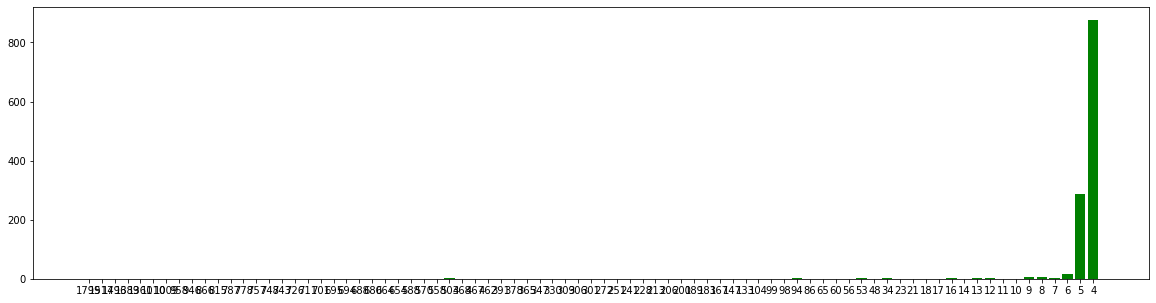

In [43]:
plot_communities_dimentions(coms_demon_tuple)

In [44]:
# Misure utilizzate nell'analisi
print(print_bold_str("Average Internal Degree:"), coms_demon.average_internal_degree())
print(print_bold_str("Erdos Renyi Modularity:"), coms_demon.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), coms_demon.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), coms_demon.modularity_density())
print(print_bold_str("Z Modularity:"), coms_demon.z_modularity())
print(print_bold_str("Triangle Partecipation Ratio:"), coms_demon.triangle_participation_ratio())

Average Internal Degree: FitnessResult(min=2.5, max=22.314115308151095, score=3.9530351033295603, std=3.088618698159595)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=7.037843309744861, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.15753511277426357, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=-2661.3342665864543, std=None)


C:\Users\valen\PYTHON_3.7\lib\site-packages\cdlib\evaluation\fitness.py:717: RuntimeWarning: invalid value encountered in sqrt
  res = (mmc - dc2m) / np.sqrt(dc2m * (1 - dc2m))


Z Modularity: FitnessResult(min=None, max=None, score=nan, std=None)
Triangle Partecipation Ratio: FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


In [45]:
results = pquality.pquality_summary(g, coms_demon_tuple)
results['Indexes']

,min,max,avg,std
Index,,,,
Internal Density,0.002301,0.250000,0.233122,0.055756
Edges inside,5.000000,14888.000000,246.615987,1337.926821
Average Degree,2.500000,22.314115,3.953035,3.088619
FOMD,0.000000,0.500000,0.043856,0.132068
TPR,1.000000,1.000000,1.000000,0.000000
Expansion,0.000000,196.000000,14.391419,27.797495
Cut Ratio,0.000000,0.013180,0.000971,0.001871
Conductance,0.000000,0.984925,0.480597,0.324655
Normalized Cut,0.000000,0.993770,0.488244,0.329417


In [46]:
results['Modularity']

,value
Index,
Modularity (no overlap),0.157535


# Analisi utili per la comparison degli algoritmi utilizzati

Algoritmi overlapping e coverage

In [47]:
# Prendiamo kclique dal file pickle creato 
import pickle
with open('kclique.pickle', 'rb') as f:
    coms_k = pickle.load(f)

In [48]:
coms_k_tuple = get_list_of_tuples_from_NodeClustering(coms_k)

In [49]:
# True se il clustering è overlapping, False altrimenti
print('Kclique overlapping:',coms_k.overlap) 
print('Louv overlapping:',coms_louv.overlap)
print('Label overlapping:',coms_label.overlap)
print('Demon overlapping:',coms_demon.overlap)

Kclique overlapping: True
Louv overlapping: False
Label overlapping: False
Demon overlapping: True


In [50]:
# Percentuale dei nodi coperti dalle communities
print('Kclique coverage:',coms_k.node_coverage) 
print('Louv coverage:',coms_louv.node_coverage)
print('Label coverage:',coms_label.node_coverage)
print('Demon coverage:',coms_demon.node_coverage)

Kclique coverage: 0.753546218487395
Louv coverage: 1.0
Label coverage: 1.0
Demon coverage: 0.648


In [51]:
# evaluation grado interno medio delle communities trovate
coms_k.average_internal_degree(summary=False)
coms_louv.average_internal_degree(summary=False)
coms_label.average_internal_degree(summary=False)
coms_demon.average_internal_degree(summary=False)

[16.55141745414119,
 17.997363216875414,
 17.37433155080214,
 17.828653707703385,
 18.074944893460692,
 19.584158415841586,
 19.645193260654114,
 18.718162839248436,
 18.651162790697676,
 17.187066974595844,
 18.211042944785277,
 20.548919949174078,
 19.308483290488432,
 20.8665785997358,
 20.510695187165776,
 17.814266487214,
 17.25619834710744,
 20.71167369901547,
 20.904422253922966,
 18.49208633093525,
 18.89048991354467,
 17.98546511627907,
 19.241176470588236,
 21.400602409638555,
 21.807339449541285,
 17.928571428571427,
 19.656140350877195,
 18.587813620071685,
 22.314115308151095,
 19.041749502982107,
 20.423076923076923,
 18.004282655246254,
 19.186147186147185,
 19.82608695652174,
 20.280423280423282,
 14.64109589041096,
 19.04899135446686,
 14.93939393939394,
 18.699029126213592,
 21.784313725490197,
 16.07308970099668,
 18.66176470588235,
 20.207171314741036,
 16.240663900414937,
 15.921052631578947,
 12.938967136150234,
 12.16504854368932,
 15.14,
 17.597883597883598,
 14

In [52]:
# evaluation grado interno medio delle communities trovate SUMMARY
print('Kclique avg degree:',evaluation.average_internal_degree(g, coms_k))
print('Louv avg degree:',evaluation.average_internal_degree(g, coms_louv))
print('Label avg degree:',evaluation.average_internal_degree(g, coms_label))
print('Demon avg degree:',evaluation.average_internal_degree(g, coms_demon))

Kclique avg degree: FitnessResult(min=2.0, max=10.54178044784271, score=2.7626688662173766, std=0.7116964494780297)
Louv avg degree: FitnessResult(min=1.0, max=6.46782431052094, score=2.0657841788855262, std=1.0790353523226504)
Label avg degree: FitnessResult(min=1.0, max=8.150467669784465, score=1.9717063534546693, std=0.9093002123641278)
Demon avg degree: FitnessResult(min=2.5, max=22.314115308151095, score=3.9530351033295603, std=3.088618698159595)


# Graph visualization

In [53]:
'''
from cdlib import viz

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, coms_louv, pos, figsize=(5, 5))
'''

'\nfrom cdlib import viz\n\npos = nx.spring_layout(g)\nviz.plot_network_clusters(g, coms_louv, pos, figsize=(5, 5))\n'

# Comparison

## NMI

Il coefficiente NMI può essere utilizzato sotto due condizioni:

- le partizioni comparate includono lo stesso insieme di nodi (nel nostro caso tutto il grafo)

- le paartizioni comparate sono non overlapping

0 no correlazione, 1 perfetta correlazione

In [54]:
# Comparison label propagation, louvain
# Demon e kclique non coprono tutto il dataset e sono overlapping
evaluation.normalized_mutual_information(coms_label, coms_louv)

MatchingResult(score=0.6123837151801009, std=None)

# Plot

Given one (or more) clustering 
it could be useful to visualize how a given fitness function distributes over the communities.

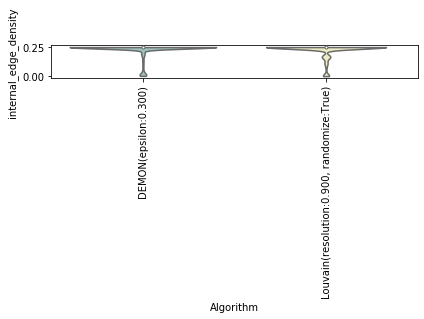

In [55]:
from cdlib import viz
viz.plot_com_stat([coms_demon, coms_louv], evaluation.internal_edge_density)

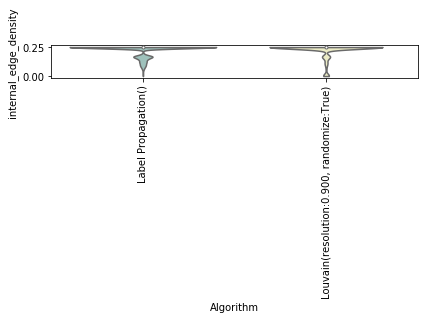

In [56]:
viz.plot_com_stat([coms_label, coms_louv], evaluation.internal_edge_density)

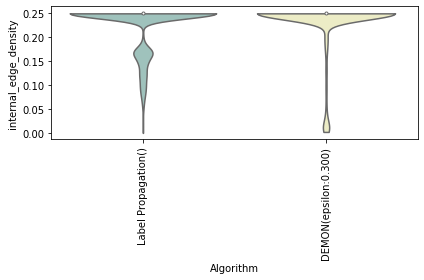

In [57]:
viz.plot_com_stat([coms_label, coms_demon], evaluation.internal_edge_density)

# Scatter plot

Another simple visualization type that allows getting a few insights 
on community characteristics is the scatter plot.
We can easily pair-wise compare fitness functions for one or more clustering as follows:

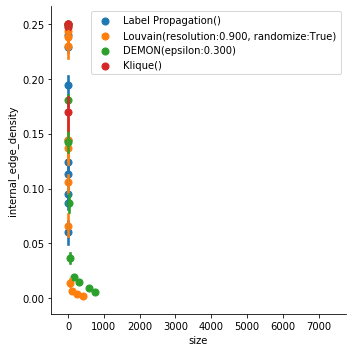

In [58]:
from cdlib import viz
viz.plot_com_properties_relation([coms_label, coms_louv,coms_demon,coms_k], evaluation.size, evaluation.internal_edge_density)

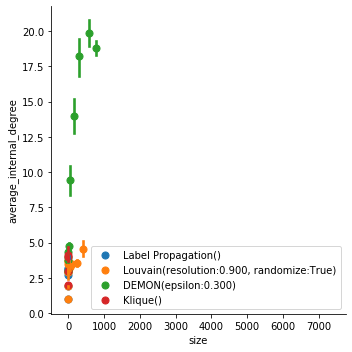

In [59]:
from cdlib import viz
viz.plot_com_properties_relation([coms_label, coms_louv,coms_demon,coms_k], evaluation.size, evaluation.average_internal_degree)

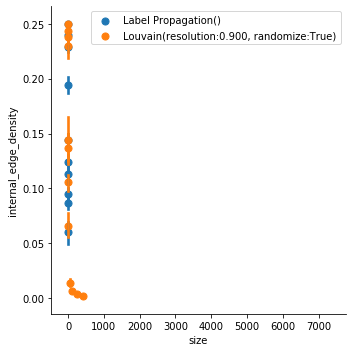

In [60]:
viz.plot_com_properties_relation([coms_label, coms_louv], evaluation.size, evaluation.internal_edge_density)

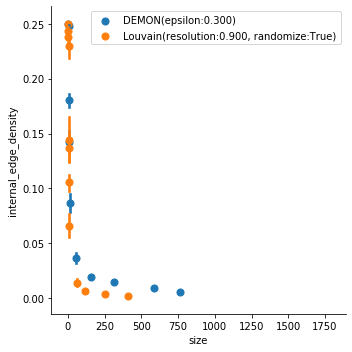

In [61]:
viz.plot_com_properties_relation([coms_demon, coms_louv], evaluation.size, evaluation.internal_edge_density)

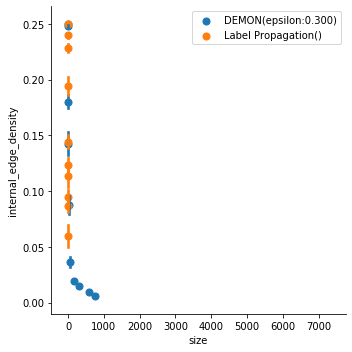

In [62]:
viz.plot_com_properties_relation([coms_demon, coms_label], evaluation.size, evaluation.internal_edge_density)

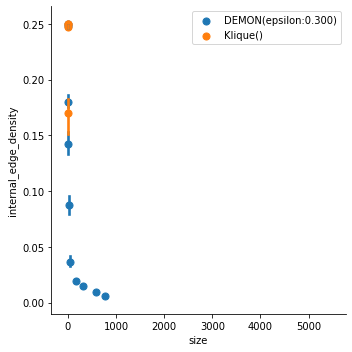

In [63]:
viz.plot_com_properties_relation([coms_demon, coms_k], evaluation.size, evaluation.internal_edge_density)

In [64]:
# Notiamo che louvain hanno dimensioni minori e internal edge density maggiore

# Matrix

Finally, we can also compare different clustering obtained on the same graph by alternative algorithms among them. 

Va fatto su communities non overlapping e che coprono la stessa porzione di dataset

In [65]:
# KCLIQUE
print(coms_k.overlap) # Wehter the clustering is overlapping or not
print(coms_k.node_coverage) # Percentage of nodes covered by the clustering


True
0.753546218487395


In [66]:
# LOUV
print(coms_louv.overlap) # Wehter the clustering is overlapping or not
print(coms_louv.node_coverage) # Percentage of nodes covered by the clustering

False
1.0


In [67]:
# LABEL
print(coms_label.overlap) # Wehter the clustering is overlapping or not
print(coms_label.node_coverage) # Percentage of nodes covered by the clustering

False
1.0


In [68]:
# DEMON
print(coms_demon.overlap) # Wehter the clustering is overlapping or not
print(coms_demon.node_coverage) # Percentage of nodes covered by the clustering

True
0.648


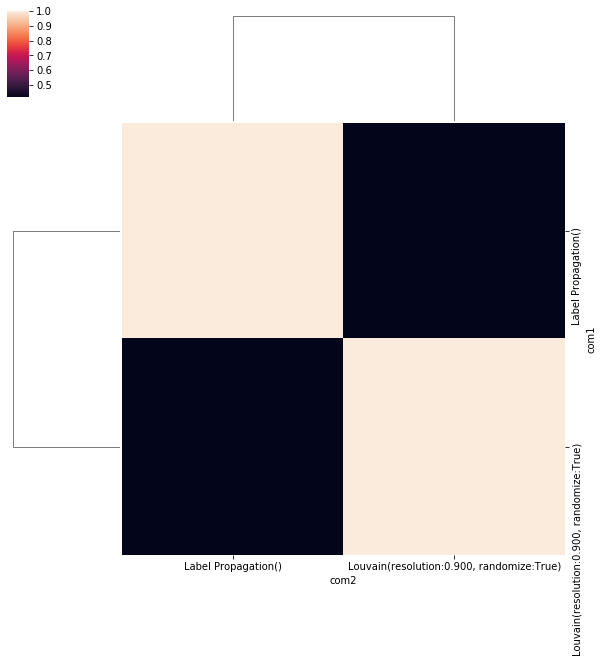

In [69]:
leiden_coms = algorithms.leiden(g)
wp_coms = algorithms.walktrap(g)

viz.plot_sim_matrix([coms_label,coms_louv],evaluation.adjusted_mutual_information)

#  NF1 score label propagation

The NF1 score is an alternative to NMI that can be used to compare any kind of partitions (overlapping/non overlapping, complete/partial coverage). It allows also to visualize the results in a Precision-Recall space.


https://www.researchgate.net/publication/287204505_A_novel_approach_to_evaluate_community_detection_algorithms_on_ground_truth

To do that we deﬁne two measures, namely community precision and community recall, which provide informa-
tion about how much the nodes of a given community tend to be in the same ground truth community. Given a pair (x,y)the two measures describe the overlap of their members: a perfect match is obtained when both precision and recall are 1.

Community precision quantiﬁes the level of label homophily between a community and a ground truth community, while the community recall quantiﬁes the ratio of nodes in the ground truth community covered by a given algorithm community

We then compute the proposed community precision and community recall metrics on the produced community sets in order to compare them on the ground truth.

The evaluation can be also summarized into a single number using the F1-measure (the harmonic mean of community precision and community recall, solita formula vedi paper), which provides a clear and concise evaluation of the quality of a community set. The mean F1, along with its standard deviation, makes possible to compare the performances of different algorithms on the same network with ground truth communities

In [70]:
#! pip install nf1

In [71]:
from networkx.algorithms import community

In [72]:
from nf1 import NF1

In [73]:
# Confronto label prop e louv
nf = NF1(coms_label_tuple,coms_louv_tuple)
results = nf.summary()
results['scores']

,Value
Index,
Ground Truth Communities,792.000000
Identified Communities,2110.000000
Community Ratio,2.664141
Ground Truth Matched,1.000000
Node Coverage,1.000000
NF1,0.140436


We observe how the average F1-measure is useful to understand
two main aspects of community evaluation:

•First, it summarizes how well the communities produced by an algorithm corre-
sponds to the ground truth communities. For instance, from our experiments is
clear how LO UVAIN shows lower correspondence with the ground truth than all
the other algorithms: this result is clearly due to the so called scale problem of
modularity based approaches. Indeed, as shown from all the density scatter plots,
LOUVAIN produces a underestimation (low recall, high precision – i.e. LiveJournal and Youtube) of the
ground truth communities;

•Second, the F1-measure helps also in evaluating the quality of the ground truth
itself:  on the Youtube dataset for example no algorithm produces communities
with high correspondence with the ground truth ones, denoting either a low qual-
ity of the ground truth communities or that the community deﬁnition underlying
the ground truth radically differs from the community deﬁnition of the tested
algorithms

In [74]:
results['details']

,F1 min,F1 max,F1 mean,F1 mode,F1 std
0,0.0,1.0,0.374141,1.0,0.466686


The color indicates the number of community matchings having precision x and recall y:
the more red is the color the higher is the volume. We have a perfect match when both precision and recall are 1 (top-right corner of the plot): in this scenario, the algorithm community is identical to the corresponding ground truth community

The proposed visualization also allows an intuitive identiﬁcation of the community
scale:

•pairings having maximal recall and low precision (i.e. points that clusters close
to the upper left corner of the plot) identiﬁes network substructures that overes-
timate the ground truth;

•pairings having low recall and maximal precision (i.e. points that clusters close
to the lower right corner) identiﬁes network substructures that underestimate the
ground truth

The former scale tells us that the algorithm produces communities that group together more nodes than it should, while in the latter case the ground truth communities are fragmented in smaller communities.

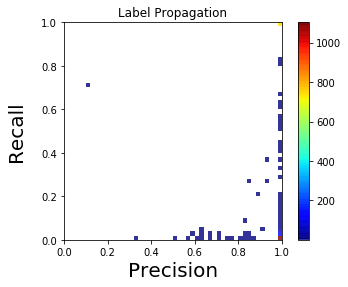

In [75]:
nf.plot(title='Label Propagation')

In [76]:
# Confronto demon e louv
nf = NF1(coms_demon_tuple, coms_louv_tuple)
results = nf.summary()
results['scores']

,Value
Index,
Ground Truth Communities,792.000000
Identified Communities,1276.000000
Community Ratio,1.611111
Ground Truth Matched,0.381313
Node Coverage,0.648000
NF1,0.021647


In [77]:
results['details']

,F1 min,F1 max,F1 mean,F1 mode,F1 std
0,0.0,1.0,0.239864,0.01,0.395462


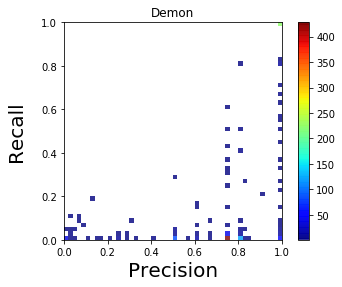

In [78]:
nf.plot(title='Demon')

In [79]:
# Confronto louv e k
nf = NF1(coms_k_tuple, coms_louv_tuple)
results = nf.summary()
results['scores']

,Value
Index,
Ground Truth Communities,792.000000
Identified Communities,2073.000000
Community Ratio,2.617424
Ground Truth Matched,0.554293
Node Coverage,0.753546
NF1,0.024745


In [80]:
results['details']

,F1 min,F1 max,F1 mean,F1 mode,F1 std
0,0.0,1.0,0.210809,0.01,0.381274


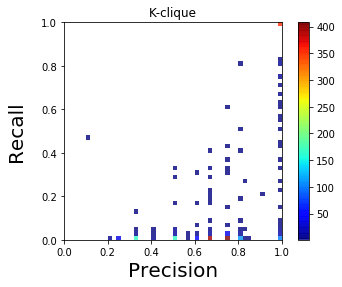

In [81]:
nf.plot(title='K-clique')